# Lab4.2 Image Segmentation; GraphCut, GrabCut, Region Growing 

In this lab, you will be familiar with Graph Cut segmentation by implementing a simple graph model. Then, for the more complex ones, you will use available tools from opencv and also MeVisLab.

# Make Sure You Already Installed PyMaxFlow on Your Laptop

As a prerequisite, you should first install "microsoft visual c++ build tools", then "pip install PyMaxflow"

## First Part: Graph Cut Segmentation

Here, we try to implement a simple graph model and use the maximum flow method to segment a very simple image for foreground (ROI) and background.

In [38]:
# Just for Read
import cv2
import numpy
from numpy import *
import maxflow
from matplotlib import pyplot as plt
from pylab import *
from PIL import Image

### Reading the Input Image and initialization of the parameters

In this model ,we are going to find the inter-pixel(nodes) weights by using this formula: Kappa*(exp(-abs(Ii-Ij)^2)/Variance) where I refers to the intensity of neighboring pixels(i and j)

Also the weights between each node and terminals(source and sink) will be defind as: -log(Pb(i)), -log(Pf(i)) where b and f refers to background and foreground.

As the first step, you are going to define approximated regions for foreground and background.

We utilized "Python Image Library" for the convenience of image cropping.

The input image is a very simple one with only one foreground and one background. The purpose is to segment the white circle of this image.

Steps:

1- Read the input image (Sample1.jpg) using "Image.open" for further processing

2- Read the input image again using "cv2.imread" and show it (for finding the approximation of foreground and background)

3- Set the initial parameter of "Kappa" and "Variance"

4- Set the coordinates of two rectangle (seed points) based on your observation of the imshowed image like this: (Xleft(Up),Yleft(Up),Xright(Down),Yright(Down)). 


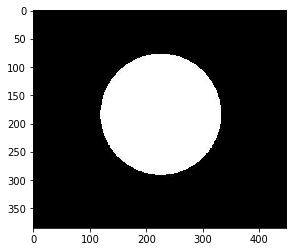

In [44]:
# TODO implement steps 1:4

# Insert the name of the image 'Sample1.jpg'
InputImage = 'Sample1.jpg'
# Read the input image using "Image.open" (This is for processing)
Im = Image.open(InputImage)
# Read the same image using "cv2.imread" (Only for showing)
IMG = cv2.imread(InputImage)
# Show IMG using "plt.imshow"
plt.imshow(IMG)
# Based on the imshowed image, find the coordinates of a rectangle for foreground and another rectangle for background.
ForeGroundRect = (150,150,350,250)
BackGroundRect = (1,2,400,100)
# Assign integers to Kappa and Variance
Kappa = 2
Variance = 100

### Generating Two Images by Cropping Foreground and Background Masks

5- Use "Im.crop" to crop the input image for both of the foreground and background rectangles

6- Convert input image, foreground and background images into array

7- Find the average of histograms for both of the foreground and background images

In [45]:
# TODO implement steps 5:7
# Cropping the image
ImFore = Im.crop(ForeGroundRect) 
ImBack = Im.crop(BackGroundRect) 
# convert all the images to arrays for calculation
Im = array(Im)
ImFore = array(ImFore)
ImBack = array(ImBack)
# Finding histogram averages from "cv2.calcHist" for foreground and background separately 
ImForeMean = mean(cv2.calcHist([ImFore],[0],None,[256],[0,256]))
ImBackMean = mean(cv2.calcHist([ImBack],[0],None,[256],[0,256]))

In [46]:
# Just for Read
#Coverting the image array to a vector for convenient.
Img = Im.reshape(-1,1) 
m,n = Im.shape
# Defining the graph
Graph = maxflow.Graph[int](m,n)
pic = maxflow.Graph[int](m,n)
# Initializing the structure
Structure = maxflow.vonNeumann_structure(ndim=2, directed=True)
# Defining terminal nodes
J = Im
# Add non-terminal nodes to graph
Nodes = Graph.add_nodes(m*n)
# Add a grid of non-terminal nodes
IdentiNodes = pic.add_grid_nodes(J.shape)
# Add edges with a fixed capacity to a grid of nodes
pic.add_grid_edges(IdentiNodes,0)
# Set the capacity of the terminal edges for multiple nodes
pic.add_grid_tedges(IdentiNodes, J, 255-J)
# Finding the maximum flow of the graph
MaxFlow = pic.maxflow()
print ("Maximum Flow Is: ",MaxFlow)
# Finding whether the given nodes belong to foreground or background?
ImOut = pic.get_grid_segments(IdentiNodes)

Maximum Flow Is:  24090


### Finding The Probability of Each Pixel Being Background or Foreground

This probability will be calculated as: -log(a/(b+c)); where a,b,c are the differences between pixel values and average of histograms.

8- Find the probability of each pixels belong to foreground and background (You have to use a 'for' loop)

In [47]:
# TODO implement step 8
# Defining the Probability values (Probablity of a pixel being background or foreground)

#initalizing the foreground/background probability vector
PrFore = zeros(shape = Im.shape)
PrBack = zeros(shape = Im.shape)
# calculating the probabilities
for i in range(m):
    for j in range(n):
        PrFore[i, j] = -log(abs(Im[i, j] - ImForeMean) / (abs(Im[i, j] - ImForeMean) + abs(Im[i, j] - ImBackMean)))
        PrBack[i,j] = -log(abs(Im[i, j] - ImBackMean) / (abs(Im[i, j] - ImForeMean) + abs(Im[i, j] - ImBackMean)))
# vectorizing the matrix
PrFore = PrFore.reshape(-1,1)
PrBack = PrBack.reshape(-1,1)

### Calculating Inter-Pixels (nodes) Weights 

The weights should be calculated through the Gaussian formula as: Kappa*(exp(-abs(Ii-Ij)^2)/Variance). This means if the neighboring pixels have the same intensity values then the weights will be Kappa*1 and if their intensities differs then the weight will be so small. For this task, 4-pixels connectivity is considered.

9- Try to compelete the next cell to calculate the weights

In [48]:
# TODO implement step 9
# Finding the interpixels weights

w = Structure
for i in range(m*n):
    # source weight
    Wsource=(PrFore[i]/(PrFore[i]+PrBack[i])) 
    # sink weight
    Wsink=(PrBack[i]/(PrFore[i]+PrBack[i])) 
    # edges between pixels and terminals (source and sink)
    Graph.add_tedge(i,Wsource,Wsink) 
    # for left neighbor pixels
    if i%n != 0: 
        w = Kappa*exp(-(abs(Img[i]-Img[i-1])**2)/Variance) # the cost function for two pixels
        Graph.add_edge(i,i-1,w,Kappa-w) # Bidirectional edges between two pixels
        # for right neighbor pixels
    if (i+1)%n != 0: 
        w = Kappa*exp(-(abs(Img[i]-Img[i+1])**2)/Variance)
        Graph.add_edge(i,i+1,w,Kappa-w) # Bidirectional edges between two pixels
        # for top neighbor pixels
    if i//n != 0: 
        w = Kappa*exp(-(abs(Img[i]-Img[i-n])**2)/Variance)
        Graph.add_edge(i,i-n,w,Kappa-w) # Bidirectional edges between two pixels
        # for bottom neighbor pixels
    if i//n != m-1: 
        w = Kappa*exp(-(abs(Img[i]-Img[i+n])**2)/Variance)
        Graph.add_edge(i,i+n,w,Kappa-w) # Bidirectional edges between two pixels

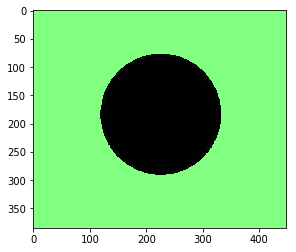

In [49]:
# Just for Read
IOut = ones(Nodes.shape)
for i in range(len(Nodes)):
    IOut[i] = Graph.get_segment(Nodes[i]) # classifying each pixel as either forground or background
ImgOut = 255*ones((Im.shape[0],Im.shape[1],3)) # initialization for 3d input
for i in range(Im.shape[0]):
    for j in range(Im.shape[1]): # converting the True/False to Pixel intensity
        if ImOut[i,j]==False:
            if len(Im.shape) == 2:
                ImgOut[i,j,0],ImgOut[i,j,1],ImgOut[i,j,2] = Im[i,j],Im[i,j],Im[i,j] # foreground for 2d image
            if len(Im.shape) == 3:
                ImgOut[i,j,0],ImgOut[i,j,1],ImgOut[i,j,2] = Im[i,j,0],Im[i,j,1],Im[i,j,2] # foreground for 3d image
        else:
            ImgOut[i,j,0],ImgOut[i,j,1],ImgOut[i,j,2] = 128,1,128 # background color

plt.imshow(ImgOut) # plot the output image
plt.show()

### Noisy Image

10- Now, repeat the whole process for 'Sample1.jpg' which is the same as previous image but some Gaussian noise has been added.

## Second Part

In this part you are expected to employ a more efficient graph cut method through the available tools from OPENCV so that you can segment more complicated images. For this part you should segment a brain tumor, bladder and also body vertebra all from CT images.

11- Try to complete the next cell for segmenting 'Bladder.bmp'. The most important task here is to find a proper rectangle around the Bladder region. Similar to Part 1, you can imshow the image and find the proper coordinates. The only difference here is the way defining the rectangle: rect = (a,b,c,d) where a refers to X coordinate, B refers to Y coordinate, C refers to width and D refers to height of the rectangle.

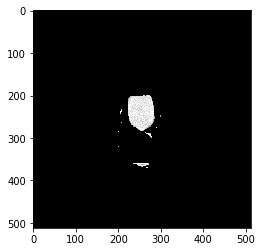

(<matplotlib.image.AxesImage at 0x2491d302ba8>, None)

In [56]:
#TODO implement step 11
# Read the image 'Bladder.bmp' using cv2.imread
Im = cv2.imread('Bladder.bmp')
Mask = zeros(Im.shape[0:2],uint8)
bgdModel = zeros((1,65),float64)
fgdModel = zeros((1,65),float64)
# Imshow the image and find proper coordinates for the foreground rectangle
plt.imshow(Im,cmap='gray')
# Insert the coordinates in a tuple
rect=(200,200,100,250)
# Call the funciton "cv2.grabCut"
cv2.grabCut(Im,Mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
Mask2 = np.where((Mask==2)|(Mask==0),0,1).astype('uint8')
Img = Im*Mask2[:,:,newaxis]
plt.imshow(Img),plt.show()

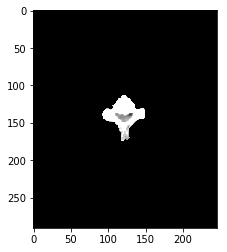

(<matplotlib.image.AxesImage at 0x24918e7a4a8>, None)

In [58]:
#TODO Repeat step 11 for 'Bodyvertebra.bmp'
Im = cv2.imread('Bodyvertebra.bmp')
Mask = zeros(Im.shape[0:2],uint8)
bgdModel = zeros((1,65),float64)
fgdModel = zeros((1,65),float64)
# Imshow the image and find proper coordinates for the foreground rectangle
plt.imshow(Im,cmap='gray')
# Insert the coordinates in a tuple
rect=(70,110,80,90)
# Call the funciton "cv2.grabCut"
cv2.grabCut(Im,Mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
Mask2 = np.where((Mask==2)|(Mask==0),0,1).astype('uint8')
Img = Im*Mask2[:,:,newaxis]
plt.imshow(Img),plt.show()

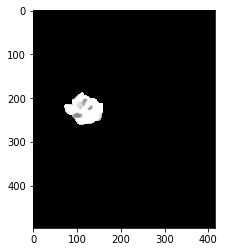

(<matplotlib.image.AxesImage at 0x24919518d68>, None)

In [60]:
#TODO Repeat step 11 for 'Brain.jpg'
Im = cv2.imread('Brain.jpg')
Mask = zeros(Im.shape[0:2],uint8)
bgdModel = zeros((1,65),float64)
fgdModel = zeros((1,65),float64)
# Imshow the image and find proper coordinates for the foreground rectangle
plt.imshow(Im,cmap='gray')
# Insert the coordinates in a tuple
rect=(60,180,100,100)
# Call the funciton "cv2.grabCut"
cv2.grabCut(Im,Mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
Mask2 = np.where((Mask==2)|(Mask==0),0,1).astype('uint8')
Img = Im*Mask2[:,:,newaxis]
plt.imshow(Img),plt.show()

## Third Part; Region Growing

Continue the lab in MeVisLab by loading Mev3 and Mev4.

12- Open the file 'RegionGrowingExample' and load the image 'S1'. Try to segment Lung regions.

13- Repeat step 12 for image 'S2'.

14- Load image 'S3' and try to segment the Body Vertebra. Can you get a good result as TODO11 ? 

In all the mentioned steps, you can double click on "Region Growing" and modify the thresholding value.

